In [ ]:
%%html
<script>
$("div.input").hide();
code_show=true; 
function code_toggle() {
 if (code_show){
   $("div.input:not(:first)").hide();
   $("div.prompt").hide();
 } else {
   $("div.input:not(:first)").show();
   $("div.prompt").show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
    .sidebar-wrapper {
        border-style: none
    }
    
    /* Pretty Pandas Dataframes */
    .dataframe * {border-color: #ffffff !important;}
    .dataframe td {
        text-align: right; 
        min-width:5em;
    }
    .dataframe tbody tr:nth-child(odd) {
        background: #f5f5f5;
    }
</style>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/show code."></form>

# NIPS impementation challenge: "Concentration of Multilinear Functions of the Ising Model with Applications to Network Data"


On synthetic data, we investigate when our statistics are successful in detecting departures from the Ising model. For our real-world data study, we analyze the Last.fm dataset from HetRec’11. Interestingly, when considering musical preferences on a social network, we find that the Ising model may be more or less appropriate depending on the genre of music.

In [50]:
import itertools

import numpy as np
import scipy as sp

import seaborn as sns
sns.set()

%matplotlib inline

## Construct samples

### Social network

Our departures from the null hypothesis are generated in the following manner, parameterized by some parameter $\tau \in [0, 1]$. The grid is initialized by setting each node independently to be $-1$ or $1$ with equal probability. We then iterate over the nodes in column major order. For the node $x$ at position $v_x = (i, j)$, we select a node $y$ at one of the following positions uniformly at random: $v_1 = (i, j + 1),\; v_2 = (i, j + 2),\; v_3 = (i + 1, j + 1),\; v_4 = (i + 1, j),\; v_5 = (i + 2,j),\; v_6 = (i + 1, j − 1)$. Then, with probability $\tau$, we set $y$ to have the same value as $x$. We imagine this construction as a type of social network model, where each individual tries to convert one of his nearby connections in the network to match his signal, and is successful with probability $\tau$.


In [162]:
# Constants
theta_critical = np.log(1 + np.sqrt(2)) / 2
print "Critical value of theta:", theta_critical

Critical value of theta: 0.44068679351


In [186]:
def array_index_from_row_col(row, col, n_cols):
    return col + row * n_cols


def get_neighbors(u, N, distance=1):
    """List all neighbors for a given vertex u on an NxN lattice."""
    row, col = u // N, u % N
    neighbors = []
    for i in range(1, distance + 1):
        # find a way to implement combinatorical way of
        # dividing i units among row and col bins
        for j in itertools.combinations_with_replacement('rc', i):
            neighbors.extend([
                array_index_from_row_col((row + j.count('r')) % N,
                                            (col + j.count('c')) % N, N),
                array_index_from_row_col((row - j.count('r')) % N,
                                            (col - j.count('c')) % N, N),
                array_index_from_row_col((row + j.count('r')) % N,
                                            (col - j.count('c')) % N, N),
                array_index_from_row_col((row - j.count('r')) % N,
                                            (col + j.count('c')) % N, N)
            ])
    return list(set(neighbors))


def random_array(number_of_nodes):
    """Return random array {-1, 1}^number_of_nodes."""
    random_array = np.random.randint(2, size=number_of_nodes)
    random_array[random_array == 0] = -1  # set 0 values to -1
    return random_array


def stochastic_social_network(n_rows, n_cols, tau):
    """Construct an n_rows x n_cols grid of up and down spins.

    :param int n_rows: number of rows
    :param int n_cols: number of columns
    :param float tau: number between 0 and 1 that parameterizes the distance
        from a perfectly random grid by introducing correlations between nearby
        spins. In particular, it is the probability that a given spin can
        'convince' one of its 'friends' (Manhattan distance 2 or less) to copy
        its value
    """
    social_grid = random_array(n_rows * n_cols)  # initialize social grid as random
    # iterate over index of vertices in column major order
    for v_x in range(len(social_grid)):
        # get row and column number for selected vertex v_x
        row, col = v_x // n_cols, v_x % n_cols
        # list nearby vertices that are:
        # - at Manhattan distance 2 or less from v_x
        # - to the right or below v_x (using periodic boundary conditions)
        v_1 = array_index_from_row_col(row, ((col + 1) % n_cols), n_cols)
        v_2 = array_index_from_row_col(row, ((col + 2) % n_cols), n_cols)
        v_3 = array_index_from_row_col(
            (row + 1) % n_rows, ((col + 1) % n_cols), n_cols)
        v_4 = array_index_from_row_col(((row + 1) % n_rows), col, n_cols)
        v_5 = array_index_from_row_col(((row + 2) % n_rows), col, n_cols)
        v_6 = array_index_from_row_col(
            ((row + 1) % n_rows), ((col - 1) % n_cols), n_cols)
        # pick uniformly at random from [v_1, ..., v_5]
        v_y = np.random.choice([v_1, v_2, v_3, v_4, v_5, v_6])
        # Pick a number between 0 and 1 with p(1) = tau
        convinced = np.random.choice([True, False], p=[tau, 1-tau])
        if convinced:
            social_grid[v_y] = social_grid[v_x]
    # TODO: reshape into 2D array
    return social_grid


class Ising_lattice(object):
    """Constructs NxN Ising lattice with nearest-neighbor interaction theta."""
    
    def __init__(self, N, theta):
        self.N = N
        self.theta = theta
        self.mixing_time = self._mixing_time()
        self.glauber_transition_probabilities = self._compute_glauber_transition_probabilities()
        # Create an Ising state by running Glauber dynamics until mixing occurs
        self.ising_lattice = self.create_ising_lattice()
    
    def _compute_glauber_transition_probabilities(self):
        return {delta: 1. / (1 + np.exp(self.theta * delta))
                for delta in (-8, -4, 0, 4, 8)}
    
    
    def _mixing_time(self):
        """Estimate mixing time for eta-high-temperature regime."""
        n_nodes = self.N ** 2
        eta = 1 - np.tanh(self.theta)
        mixing_time = int(n_nodes * np.log(n_nodes) / eta)
        return mixing_time
            
    
    def glauber_step(self, lattice):
        """Perform one step in Glauber dynamics."""
        # Choose a random spin i
        v_i = np.random.randint(self.N ** 2)
        row_i, col_i = v_i // self.N, v_i % self.N
        # Find its nearest neighbours and compute energy delta
        v_N = array_index_from_row_col(((row_i - 1) % self.N), col_i, self.N)
        v_E = array_index_from_row_col(row_i, ((col_i + 1) % self.N), self.N)
        v_S = array_index_from_row_col((row_i + 1) % self.N, col_i, self.N)
        v_W = array_index_from_row_col(row_i, ((col_i - 1) % self.N), self.N)
        delta = 2 * lattice[v_i] * (
            lattice[v_N] + lattice[v_E] + lattice[v_S] + lattice[v_W])
        # Look up transition probability p_flip
        p_flip = self.glauber_transition_probabilities[delta]
        # With probability p_flip, flip spin i
        random_number = np.random.uniform()
        if random_number < p_flip:
            lattice[v_i] *= -1
        return lattice

    
    def create_ising_lattice(self):
        """Run the Glauber dynamics long enough to reach mixing."""
        # initialize lattice at random
        lattice = random_array(self.N ** 2)
        
        for _ in range(self.mixing_time):
            lattice = self.glauber_step(lattice)
        
        return lattice
    
    
    def sample_ising_states(self, n_samples):
        """Starting from an Ising state, create a collection of n_samples."""
        intermediate_state = self.ising_lattice
        samples = []
        
        for _ in range(n_samples):
            intermediate_state = glauber_step(intermediate_state)
            samples.append(intermediate_state)
        
        return samples

In [122]:
def L(theta, sigma):
    N = len(sigma)
    return (float(theta) / N) * (
        sigma[1] * (sigma[0] - np.tanh(theta * sigma[1])) +
        sigma[N - 2] * (sigma[N - 1] - np.tanh(theta * sigma[N - 2])) +
        sum([(sigma[i - 1] + sigma[i + 1]) * (sigma[i] - np.tanh(
            theta * (sigma[i-1] + sigma[i + 1]))) for i in range(1, N - 1)])
    )


def maximum_partial_likelihood_estimator(sigma):
    """MPLE for theta under the assumption of a nearest-neighbours Ising model."""
    return sp.optimize.fsolve(L, 0.5, args=(sigma))[0]


def local_partition_function(lattice, N, external_field=0, distance=2):
    """Compute the local partition function for a lattice."""
    offset = np.tanh(external_field)
    return sum([(lattice[u] - offset) * sum([
            (lattice[v] - offset) for v in get_neighbors(u, N, distance=distance)])
                    for u in range(len(lattice))])

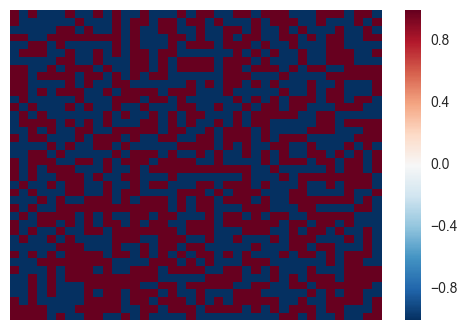

In [67]:
n_rows, n_cols, tau = 40, 40, 0
social_grid = stochastic_social_network(n_rows, n_cols, tau)
sns.heatmap(np.reshape(social_grid, (n_rows, n_cols)), xticklabels=False, yticklabels=False);

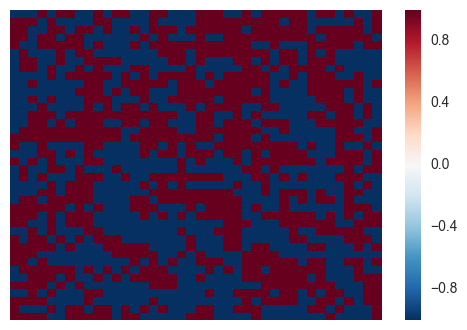

In [68]:
n_rows, n_cols, tau = 40, 40, 1
social_grid = stochastic_social_network(n_rows, n_cols, tau)
sns.heatmap(np.reshape(social_grid, (n_rows, n_cols)), xticklabels=False, yticklabels=False, cbar=True);

### Ising model


The data will be compared with an Ising model

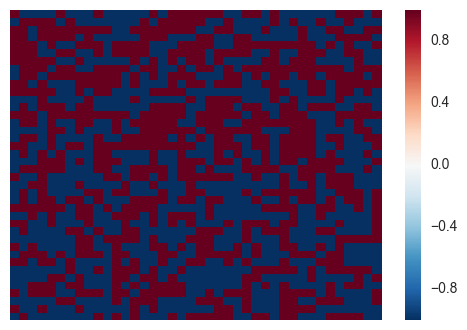

In [168]:
ising = Ising_lattice(40, 0.1)
sns.heatmap(np.reshape(ising.ising_lattice, (40, 40)), xticklabels=False, yticklabels=False, cbar=True);

## Hypothesis testing

Given the Ising model on a graph $G = (V, E)$,
$$p(\sigma)=\exp\left(\theta_v\sigma_v + \theta_{u,v}\sigma_u\sigma_v - F({\beta})\right),$$
where $\sigma$ is one state, and $\theta_v$ and $\theta_{u, v}$ a local magnetic field and magnetic interaction terms, respectively, and $F(\beta)$ proportional to the free energy.

Our null hypothesis is that the sample is generated from an Ising model in the high temperature regime on the grid, with no external field (i.e. $\theta_u = 0$ for all $u$) and a constant neares-neighbour interaction strength parameterized by $\theta$ (i.e., $\theta_{uv}=\theta$ iff nodes $u$ and $v$ are adjacent in the grid, and $0$ otherwise). For the Ising model on the grid, the critical edge parameter for high-temperature is
$\theta_c=\ln(1+\sqrt{2})/2$. In other words, we are in high-temperature if and only if $\theta\leq \theta_c$, and we can reject the null hypothesis if the MPLE estimate $\hat{\theta} > \theta_c$.

### Estimate Ising model parameters

Given a single multivariate sample, we first run the maximum pseudo-likelihood estimator (MPLE) to obtain an estimate of the model’s parameters under the null hypothesis that the sample is generated by a high-temperature Ising model.

The pseudo-likelihood is an approximation of the likelihood, where instead of the entire partition function, one needs to compute only a local partition function (is it a mean field approximation?).

Given a random vector $\sigma=(\sigma_1, \sigma_2, \ldots , \sigma_N)$ whose joint distribution is parametrized by a parameter $\theta \in \mathbb{R}$, the MPLE of $\theta$ is defined as
$$\hat{\beta}_N := \mbox{arg}\,\mbox{max}\prod_{i=1}^{N} f_i(\beta, \sigma),$$
where $f_i(\theta, \sigma)$ is the conditional probability density of $\sigma_i$ given $(\sigma_j)_{j\neq i}$.

For the case of the Ising model, this can be explicitly solved by computing the derivative with respect to $\theta$
$$L_{\sigma}(\theta) := \frac{1}{N}\sum_{i=1}^{N}m_i(\sigma)(\sigma_i - \tanh(\theta\, m_i(\sigma))),$$
with
$$m_i(\sigma) := \sum_{j=1}^{N}J_N(i, j)\,\sigma_j$$
for some $\sigma \in S_N:=\{−1, 1\}^N$ and an $N\times N$ symmetric matrix $J_N$ with zeros on the diagonals, indicating the interactions between spins on different sites.

Note that $m_i(\sigma)$ does not depend on $\sigma_i$ since the diagonal element $J_N(i,i)=0$. Interpreting $\tanh(\pm\infty) = \pm 1$, the function $L_\sigma$ can be extended to $[0,\infty]$ by defining
$L_{\sigma}(\infty):= \frac{1}{N}\sum_{i=1}^{N}\left(m_i(\sigma)\sigma_i-|m_i(\sigma)|\right)$. Then it is easy to verify (see <a href="https://mathscinet.ams.org/mathscinet-getitem?mr=2363958">Chatterjee</a>) that $\frac{1}{N}\frac{\partial}{\partial\theta}\log f_i(\theta, \sigma) = L_{\sigma}(\theta)$, and the function $L_{\sigma}(\theta)$ is a decreasing function of $\theta$. Therefore, the MPLE for $\theta$ in the Ising model is
$$\hat{\theta}_N (\sigma) := \inf\{ x \geq 0 : L_{\sigma}(x) = 0 \}.$$

In our case, our null hypothesis is that the data is generated by a nearest-neighbour Ising model with constant interaction and zero external field, in the high temperature regime.

Nearest neigbour interactions means that the matrix $J_N(i,j)$ has values $1$ on the elements with $|i-j|=1$ and zeros everywhere else, $J_N(i, j) = \delta_{|i-j|, 0}$:
$$J_N = \begin{pmatrix}
0 & \theta & 0 & 0 & \cdots & 0\\
\theta & 0 & \theta & 0 & \cdots & 0\\
0 & \theta & 0 & \theta &  & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots &\\
0 & \cdots & 0 &\theta & 0 & \theta \\
0 & \cdots & 0 &0&\theta & 0
\end{pmatrix}.$$
This greatly simplifies the equations:
$$m_i(\sigma) = \left\{
\begin{array}{cc}
\theta\sigma_2 & i=1\\
\theta\sigma_{N-1} & i=N\\
\theta(\sigma_{i-1}+\sigma_{i+1}) & 1 < i < N
\end{array}
\right.$$
So we have
$$
L_{\sigma}(\theta) = \frac{\theta}{N}\left(
\sigma_2\left(\sigma_1-\tanh(\theta\sigma_2)\right) + \sigma_{N-1}\left(\sigma_N - \tanh(\theta\sigma_{N-1})\right) + \sum_{i=2}^{N-1}\left(\sigma_{i-1}+\sigma_{i+1})(\sigma_{i} - \tanh(\theta(\sigma_{i-1} + \sigma_{i+1}))\right)
\right)
$$

In [193]:
n_rows, n_cols, tau = 40, 40, 1
social_grid = stochastic_social_network(n_rows, n_cols, tau)
theta_mple = maximum_partial_likelihood_estimator(social_grid)
print "MPLE estimate of theta:", theta_mple
print "High-temperature regime:", theta_mple <= theta_critical

MPLE estimate of theta: 0.122701001297
High-temperature regime: True


In [144]:
def test_mple_ising():
    # Construct Ising grid with pre-determined value of theta
    # under the assumption that there is no external field
    # theta = 0 corresponds to the high-temperature limit of
    # the Ising model under 0 external field. In this case, the
    # model is random.
    epsilon = 5e-2
    random_grid = random_array(40 ** 2)
    print maximum_partial_likelihood_estimator(random_grid)
    assert maximum_partial_likelihood_estimator(random_grid) < epsilon
    

We note that, to be precise, we would need to quantify the error incurred by the MPLE. For now, this step is skipped.

In [145]:
test_mple_ising()

0.0


### MCMC using MPLE parameters
If we cannot reject the null hypothesis outright from the model parameters, we use Markov Chain Monte Carlo (MCMC) on a model with the MPLE parameters to determine a range of values for our statistic. Specifically, we run the Glauber dynamics for $O(n\log n)$ steps to generate a sample from the grid Ising model with parameter $\hat{\theta}$.

Both the Metropolis-Hastings and the Glauber algorithms satisfy detailed balance. The Glauber algorithm computes the transition probability of one state to another $S_i\rightarrow S_j$ as:
$$P(S_i \rightarrow S_j) = \frac{1}{1 + e^{\theta\Delta E_{ji}}}$$

We use the local partition function as a statistic:
$$Z_{\mbox{local}} =  \sum_{u=(i,j)} \sum_{v=(k,l): d(u,v)\leq 2} X_uX_v,$$
with $d(u, v)$ the Manhattan distance between two lattice sites $u$ and $v$.

Our statistic is bilinear in the Ising model, and thus enjoys the strong concentration properties explained earlier in this paper. Note that since the Ising model will be in the high-temperature regime, the Glauber dynamics mix rapidly, and we can efficiently sample from the model using MCMC. Finally, given the range of values for the statistic determined by MCMC, we reject the null hypothesis if p ≤ 0.05.

In [194]:
ising_mple = Ising_lattice(N=40, theta=theta_mple)

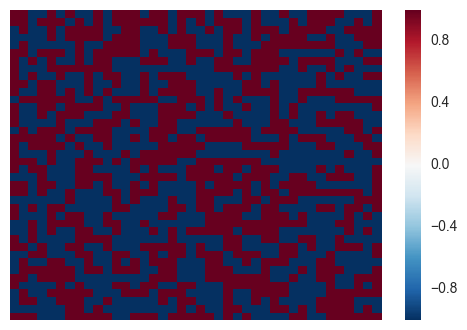

In [195]:
sns.heatmap(
    np.reshape(ising_mple.ising_lattice, (40, 40)),
    xticklabels=False, yticklabels=False, cbar=True);

In [200]:
N = 40
sampled_values_statistic = sorted([local_partition_function(
    Ising_lattice(N, theta=theta_mple).ising_lattice, N, distance=2) for _ in range(100)])

DescribeResult(nobs=100, minmax=(456, 1784), mean=1104.96, variance=90833.816565656569, skewness=-0.041433045201350785, kurtosis=-0.7589010824952256)


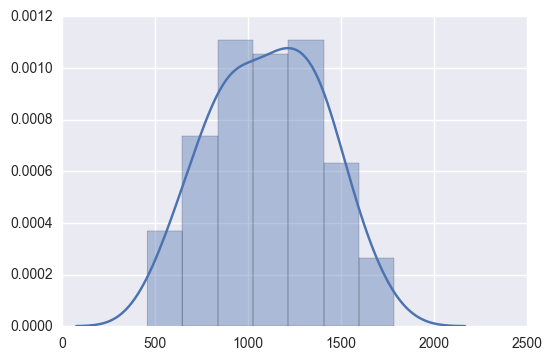

In [206]:
print sp.stats.describe(sampled_values_statistic)
sns.distplot(sampled_values_statistic);

Compare this to the value of the local partition function for our social network lattice

In [204]:
statistic_social_grid = local_partition_function(social_grid, N, distance=2)
p_value_est = 
reject_null = ((statistic_social_grid > sampled_values_statistic[95]) or (statistic_social_grid < sampled_values_statistic[5]))
print "Reject null hypothesis (used cutoff p = 0.05)!" if reject_null else "Cannot reject null hypothesis."

Reject null hypothesis (used cutoff p = 0.05)!


So it looks like the case $\tau = 1$ is quite easy to distinguish from an Ising grid.

### Plot probability of rejecting null hypothesis vs tau

In order to test the power of this statistic in rejecting the null hypothesis for cases when the departure from high temperature Ising is less pronounced, we plot the probability of rejecting vs $\tau$.